In [1]:
# use gene_feature_plot conda environment
import pandas as pd
import numpy as np
#import pygenometracks.tracks as pygtk
# use bokeh to visualise mutations
from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO
# from bokeh.plotting import figure
# from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
# from bokeh.models.glyphs import Text, Rect
# from bokeh.layouts import gridplot
# from bokeh.io import export_svg
# from bokeh.io import export_png
# from Bio.Align.Applications import MuscleCommandline
import subprocess
import os
# from IPython.display import HTML
# import panel as pn
# import panel.widgets as pnw
# pn.extension()
from matplotlib import rcParams

# import panel as pn
import matplotlib.pyplot as plt
import biotite.sequence.graphics as graphics
import biotite.application.muscle as muscle
import biotite.sequence.io.fasta as fasta
import biotite.sequence as seq

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../TRAMP')


import class_customtranslator_qpcrs
#import functions
from candidate_TFBSs_for_qpcrs import move_position, make_plot, gb_file_to_seqrecord, preprocess_record, slice_sequence_with_features, slice_feature, end_violation_pos, start_violation_pos

In [2]:
#plant lines: 69-9 NLP7, 125-4 ARF9 NLP7, 130-4 ARF18, 134-3 DREB26, 139-9 ARF9
# manually made fasta file containing 40bp sequence containing the mutation with the genomic start and stop positions
# take the centre of each mutation genomic position and annotate it on to the promoter sequence
# mutation locations relative to TSS
# NLP7 TSS: 12479528
# ARF9 TSS: 12451143
# ARF18 TSS: 22887889
# DREB26 TSS: 7696427

In [3]:
def set_rc_params():
    #set plot parameters
    rcParams['xtick.major.width'] = 1
    rcParams['ytick.major.width'] = 1
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Arial']
    rcParams['lines.linewidth'] = 1
    #allow font to be edited later in pdf editor
    rcParams ['pdf.fonttype'] = 42
    # font_size = 11
    # rcParams["font.size"] = font_size


    #make svg text editable
    rcParams['svg.fonttype'] = 'none'

In [4]:
def view_alignment(file,input_location,output_location, prom_name, start, stop, fontsize=11):
    
    #get file name
    name = os.path.splitext(file)[0]
    #get file name without location
    name = os.path.basename(name)

    #read in fasta file with multiple sequences
    seqs = fasta.FastaFile.read(file)
    #create dictionary  where headers are keys and sequences are values
    seq_dict = fasta.get_sequences(seqs)
   
    # Perform a multiple sequence alignment using MUSCLE
    app = muscle.MuscleApp(list(seq_dict.values()))
    app.start()
    app.join()
    alignment = app.get_alignment()
    #get gapped seqs
    #gapped_seqs = alignment.get_gapped_sequences()

    labels = list(seq_dict.keys())


    fig,(ax,crop_ax) = plt.subplots(2,1,figsize=(8.0, 0.54*len(labels)))
    #ax = fig.add_subplot(111)
    #crop_ax = fig.add_subplot(111)
    
    #order = app.get_alignment_order()

    graphics.plot_alignment_type_based(
        ax, alignment, labels=labels,
    show_numbers=False, show_line_position=False,color_scheme="clustalx",
    )
    #change x range to 0,40
    ax.set_xlim(0,40)
    #change font size
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    #save figure in same location as file as svg file
    #plt.tight_layout()
    #promoter_names=dict([('promoter_name1',"nlp7-at4g24020_ensembl_plant"),])#('promoter_name1','arf9-at4g23980_ensembl_plant')
    promoter_names=dict([('promoter_name7',"nlp7-at4g24020_ensembl_plant"),
        ('promoter_name6',"nlp6-at1g64530_ensembl_plant"),
        #('promoter_name9',"tga1-at5g65210_ensembl_plant"),
        ('promoter_name3',"arf18-at3g61830_ensembl_plant"),
        #('promoter_name3',"arf9-at4g23980_ensembl_plant"),
        ('promoter_name2',"anac032-at1g77450_ensembl_plant"),
        #('promoter_name3',"anr1-at2g14210_ensembl_plant"),
        ('promoter_name4',"dreb26-at1g21910_ensembl_plant"),
        ('promoter_name5',"nir1-at2g15620_ensembl_plant"),
        ('promoter_name1','arf9-at4g23980_ensembl_plant')])
    #sort promoter names dictionary in alphabetical order
    promoter_names = {k: v for k,v in sorted(promoter_names.items(), key=lambda item: item[0])}
 
    #create empty dictionary
    seqrecords = {}
    #Define the number of bp downstream of the TSS to include.
    #Any sequence further downstream will be trimmed. Any sequence upstream of the promoter annotation will be trimmed
    bp_downstream_of_TSS = 1000
    for k,v in promoter_names.items():             
        #add to new dictionary of seqrecords
        seqrecords[k] = gb_file_to_seqrecord(v,input_location,bp_downstream_of_TSS)
    
    make_plot(seqrecords, promoter_names, input_location, output_location, bp_downstream_of_TSS, crop_ax, start, stop,prom_name, openchromatin=True, dnaseI=False, crop_record=True,)


    # add a rectangular border around the gene region
    # length of the gene region
    # region_length = stop - start

    # # linethickness converter so that start and width are offset by the linethickness for the rectangle
    # linewidth = 1.03
    # linewidth_offset = linewidth * 2.5
    # # start location of rectangle
    # start_loc = (region_length + linewidth_offset) / region_length
    # print(f'start_loc={start_loc}')
    # # stop = (1/4550)*xlength+xstart
    # # height of rectangle
    # height = 1.3
    # # width of rectangle
    # width = (region_length - 2 * linewidth_offset) / region_length
    # # plot the rectangle on each subplot relative to that subplot location
    # rect = plt.Rectangle(
    #     # (lower left corner coordinates), width, height
    #     (start_loc, 0.01),
    #     width,
    #     height / 2,
    #     fill=False,
    #     color="black",
    #     linewidth=linewidth,
    #     transform=crop_ax.transAxes,
    # )
    # fig.add_artist(rect)


    fig.savefig(f'{output_location}/{name}mutation_plot.svg', format='svg', dpi=1200,bbox_inches="tight",transparent=True, pad_inches=0.2)

    # graphics.plot_alignment_type_based(
    #     ax, alignment[:200, order.tolist()], labels=[hits[i] for i in order],
    #     show_numbers=True, color_scheme="clustalx"
    # )

In [5]:
def make_plots(mutation_name,gene_name,input_location,start,stop, TSS_location):
    """function to make the mutation alignment to C0l-0,
     show what TFBS if any bind there and then show location in whole promoter figure. 
     Use genomic locations for start, stop and TSS_location"""
     #first make output_location folder

    output_location = f"{input_location}/plots/{mutation_name}"
    try:
        # Create target Directory
        os.mkdir(output_location)
        print("Directory ", output_location, " created")
    except FileExistsError:
        print("Directory ", output_location, " already exists")
    file_location=f'{input_location}/{mutation_name}.fa'
    #get new start and stop locations relative to TSS_location
    new_start = start - TSS_location 
    new_stop = stop - TSS_location
    #make plots
    view_alignment(file_location,input_location,output_location,gene_name, new_start, new_stop)

    

Directory  ../../data/CRISPR_library/shortlist_mutations/plots  already exists
Directory  ../../data/CRISPR_library/shortlist_mutations/plots/69-9_nlp7_mutation1  already exists
arf9-at4g23980_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
anac032-at1g77450_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
arf18-at3g61830_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
dreb26-at1g21910_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nir1-at2g15620_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp6-at1g64530_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp7-at4g24020_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/biotite/application/muscle/app3.py:119: UserWarning: MUSCLE did not write a tree file from the second iteration
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented root_open_chromatin feature?
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented shoot_open_chromatin feature?
  warnings.warn(


RGBA
converting_image
Directory  ../../data/CRISPR_library/shortlist_mutations/plots/125-4_arf9_mutation1  already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/biotite/application/muscle/app3.py:119: UserWarning: MUSCLE did not write a tree file from the second iteration
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented root_open_chromatin feature?
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented shoot_open_chromatin feature?
  warnings.warn(


arf9-at4g23980_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
anac032-at1g77450_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
arf18-at3g61830_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
dreb26-at1g21910_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nir1-at2g15620_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp6-at1g64530_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp7-at4g24020_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
RGBA
converting_image
Directory  ../../data/CRISPR_library/shortlist_mutations/plots/125-4_nlp7_mutation1  already exists
arf9-at4g23980_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
anac032-at1g77450_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
arf18-at3g61830_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
dreb26-at1g21910_ensembl_plant_shortened_1000bp_

/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented root_open_chromatin feature?
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented shoot_open_chromatin feature?
  warnings.warn(


RGBA
converting_image
Directory  ../../data/CRISPR_library/shortlist_mutations/plots/125-4_nlp7_mutation2  already exists
arf9-at4g23980_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
anac032-at1g77450_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
arf18-at3g61830_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
dreb26-at1g21910_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nir1-at2g15620_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp6-at1g64530_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp7-at4g24020_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented root_open_chromatin feature?
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented shoot_open_chromatin feature?
  warnings.warn(


RGBA
converting_image
Directory  ../../data/CRISPR_library/shortlist_mutations/plots/130-4_arf18_mutation1  already exists
arf9-at4g23980_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
anac032-at1g77450_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
arf18-at3g61830_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
dreb26-at1g21910_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nir1-at2g15620_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp6-at1g64530_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp7-at4g24020_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented root_open_chromatin feature?
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented shoot_open_chromatin feature?
  warnings.warn(


RGBA
converting_image
Directory  ../../data/CRISPR_library/shortlist_mutations/plots/130-4_arf18_mutation2  already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/biotite/application/muscle/app3.py:119: UserWarning: MUSCLE did not write a tree file from the second iteration
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented root_open_chromatin feature?
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented shoot_open_chromatin feature?
  warnings.warn(


arf9-at4g23980_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
anac032-at1g77450_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
arf18-at3g61830_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
dreb26-at1g21910_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nir1-at2g15620_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp6-at1g64530_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp7-at4g24020_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
RGBA
converting_image
Directory  ../../data/CRISPR_library/shortlist_mutations/plots/134-3_dreb26_mutation1  already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/biotite/application/muscle/app3.py:119: UserWarning: MUSCLE did not write a tree file from the second iteration
  warnings.warn(


arf9-at4g23980_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
anac032-at1g77450_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
arf18-at3g61830_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
dreb26-at1g21910_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nir1-at2g15620_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp6-at1g64530_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp7-at4g24020_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented root_open_chromatin feature?
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented shoot_open_chromatin feature?
  warnings.warn(


RGBA
converting_image
Directory  ../../data/CRISPR_library/shortlist_mutations/plots/139-9_arf9_mutation1  already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/biotite/application/muscle/app3.py:119: UserWarning: MUSCLE did not write a tree file from the second iteration
  warnings.warn(


arf9-at4g23980_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
anac032-at1g77450_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
arf18-at3g61830_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
dreb26-at1g21910_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nir1-at2g15620_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp6-at1g64530_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists
nlp7-at4g24020_ensembl_plant_shortened_1000bp_downstream_of_TSS.gb already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented root_open_chromatin feature?
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented shoot_open_chromatin feature?
  warnings.warn(


RGBA
converting_image


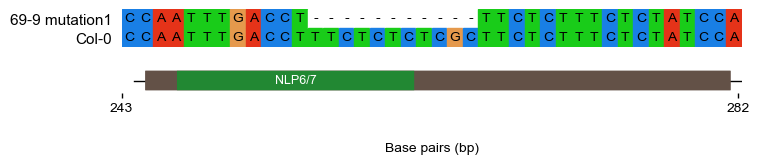

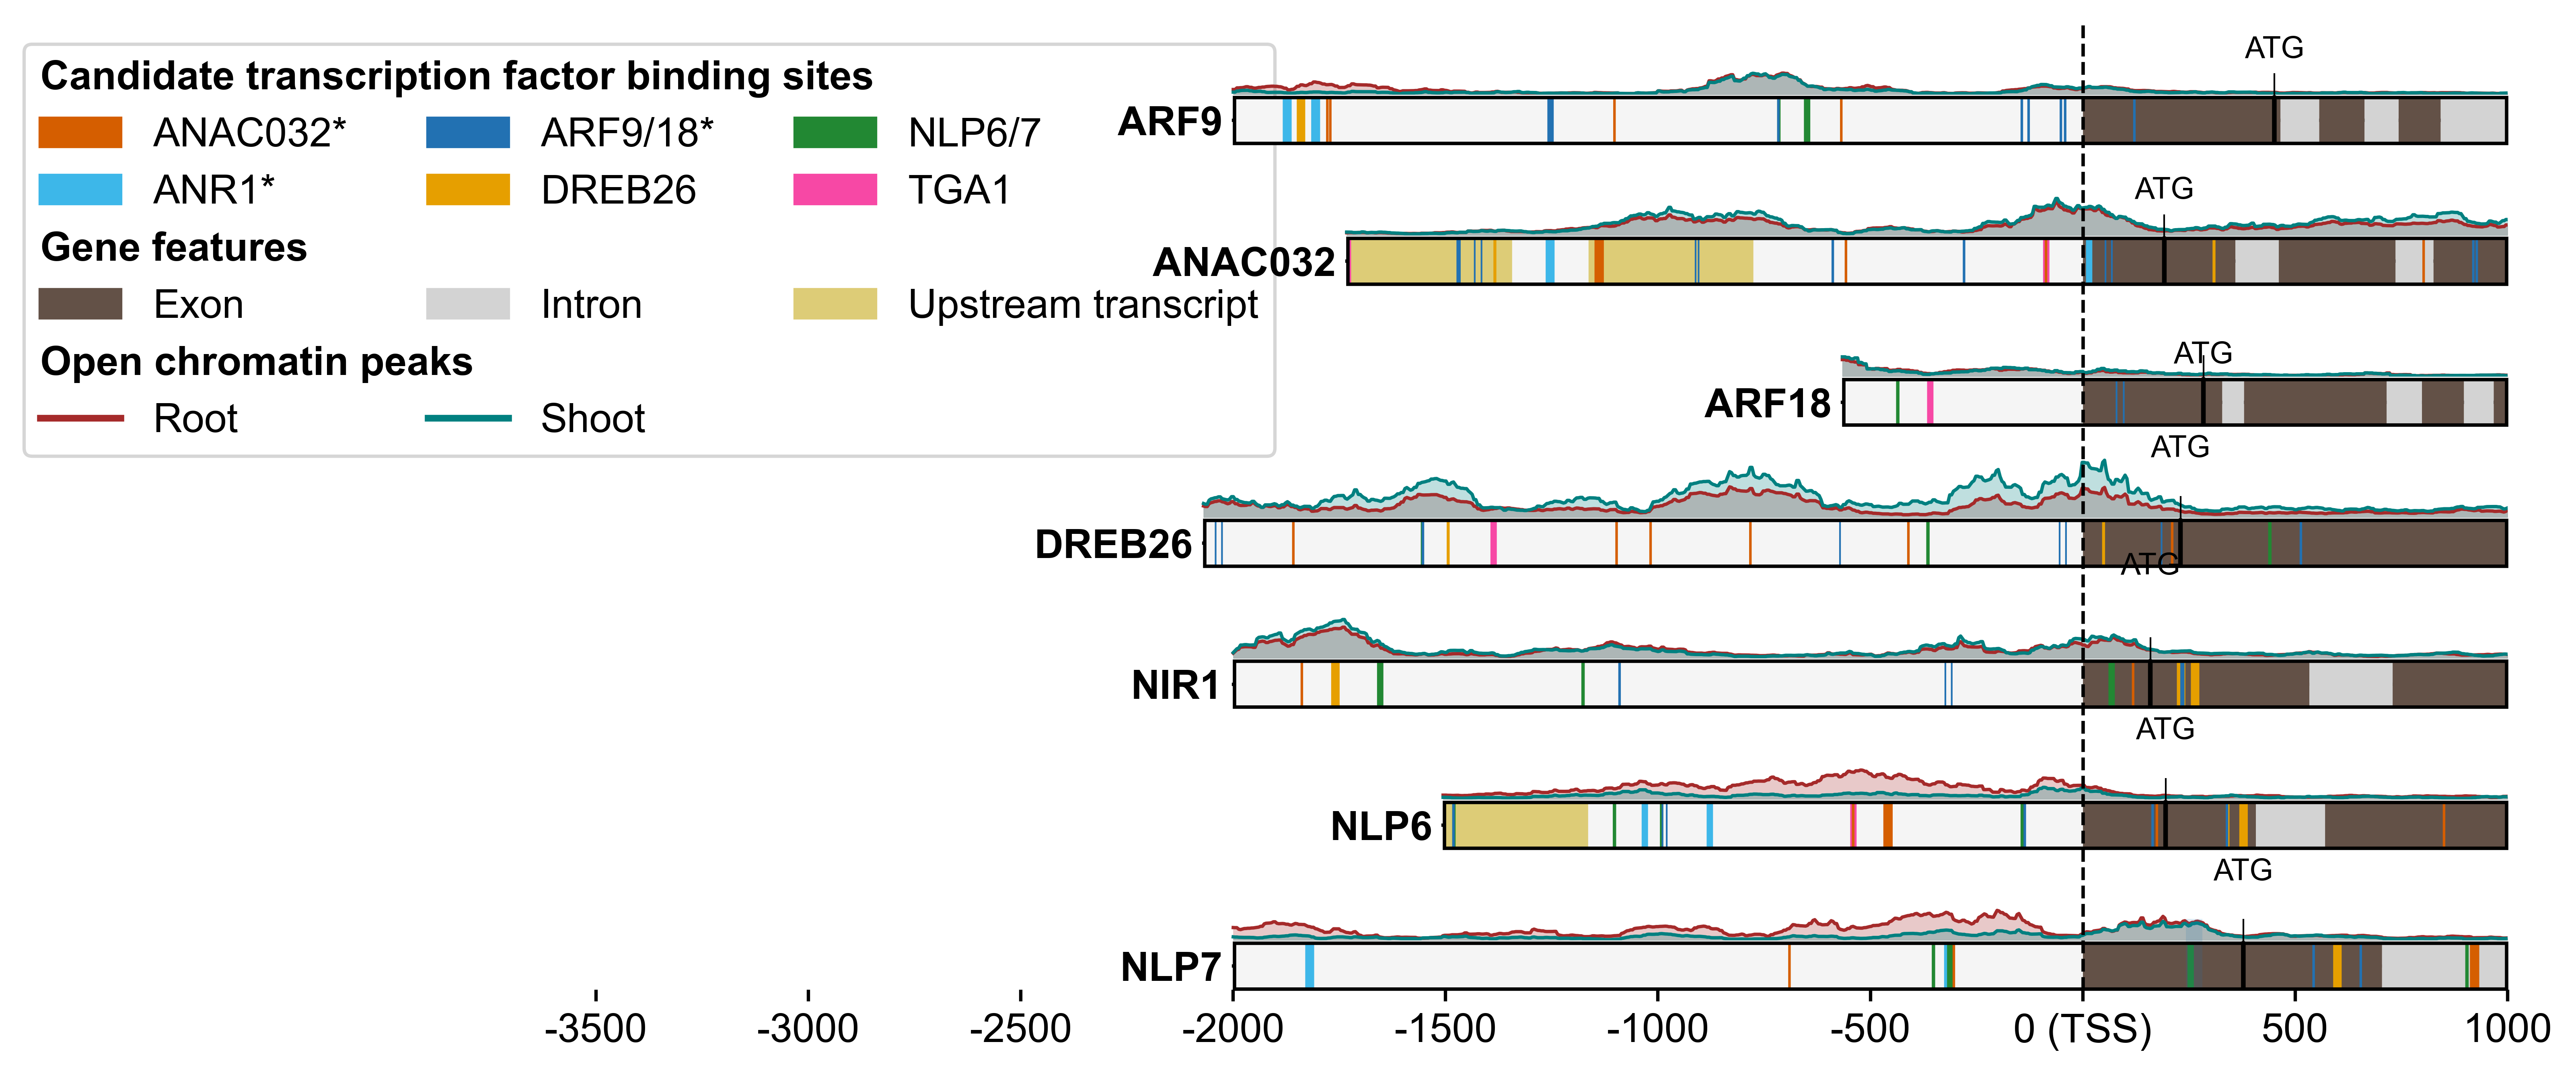

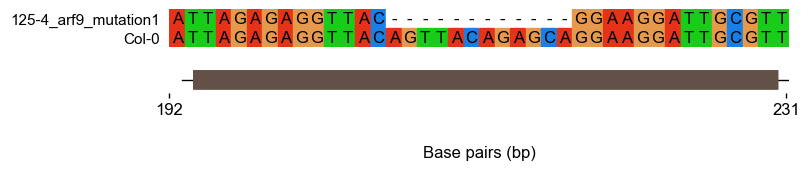

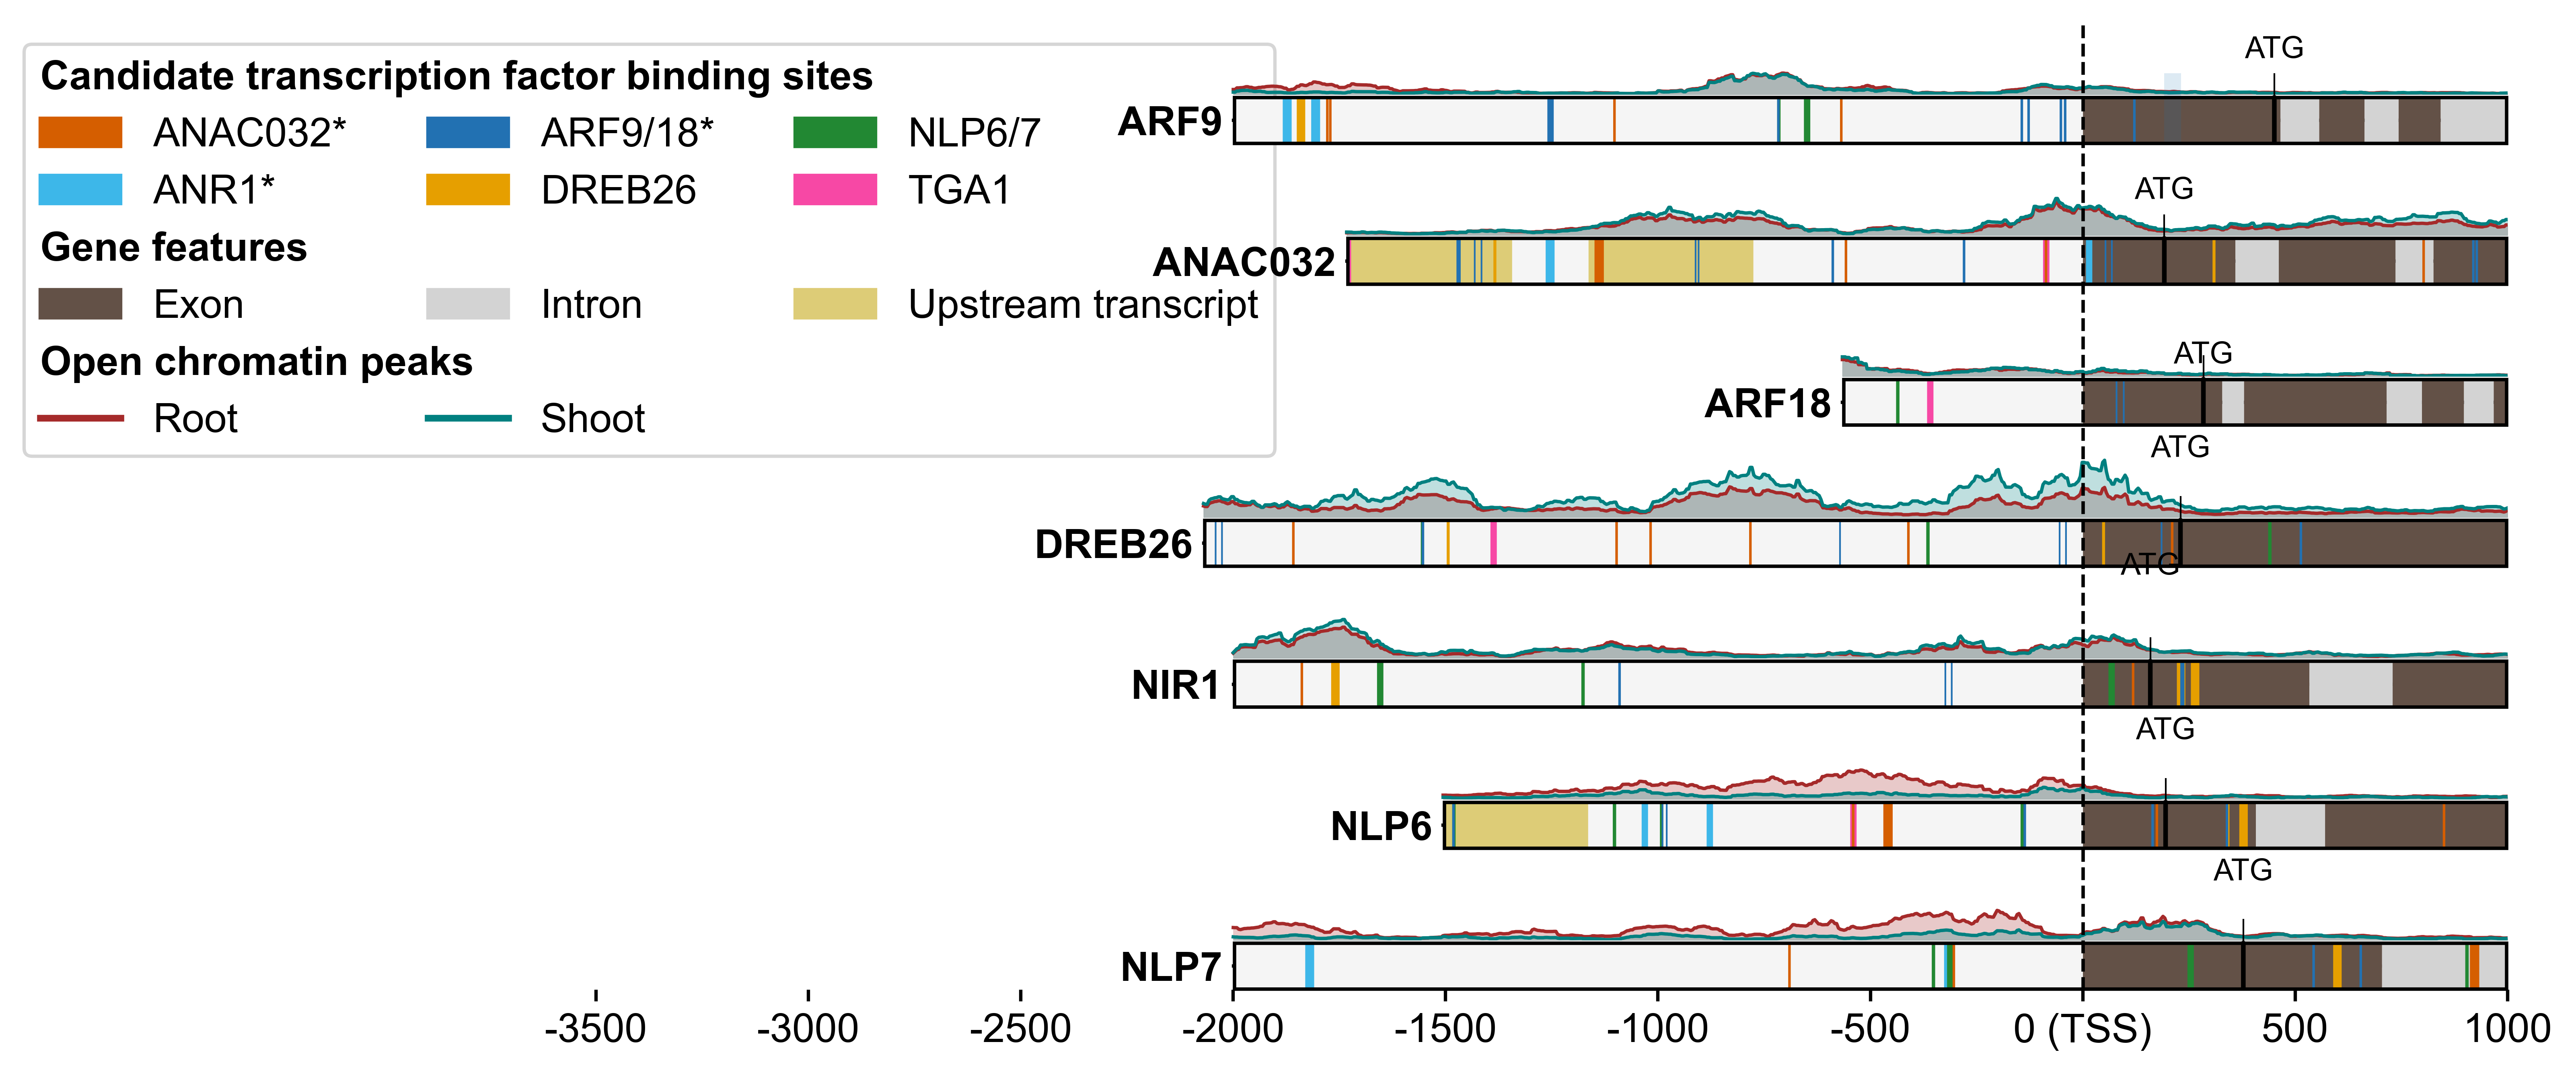

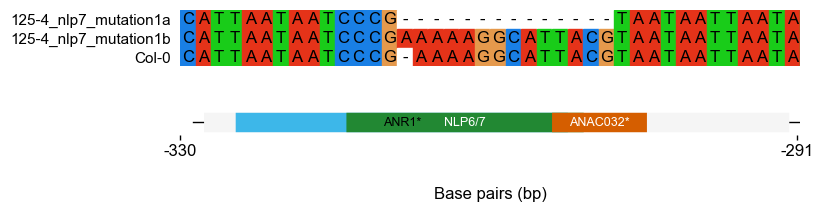

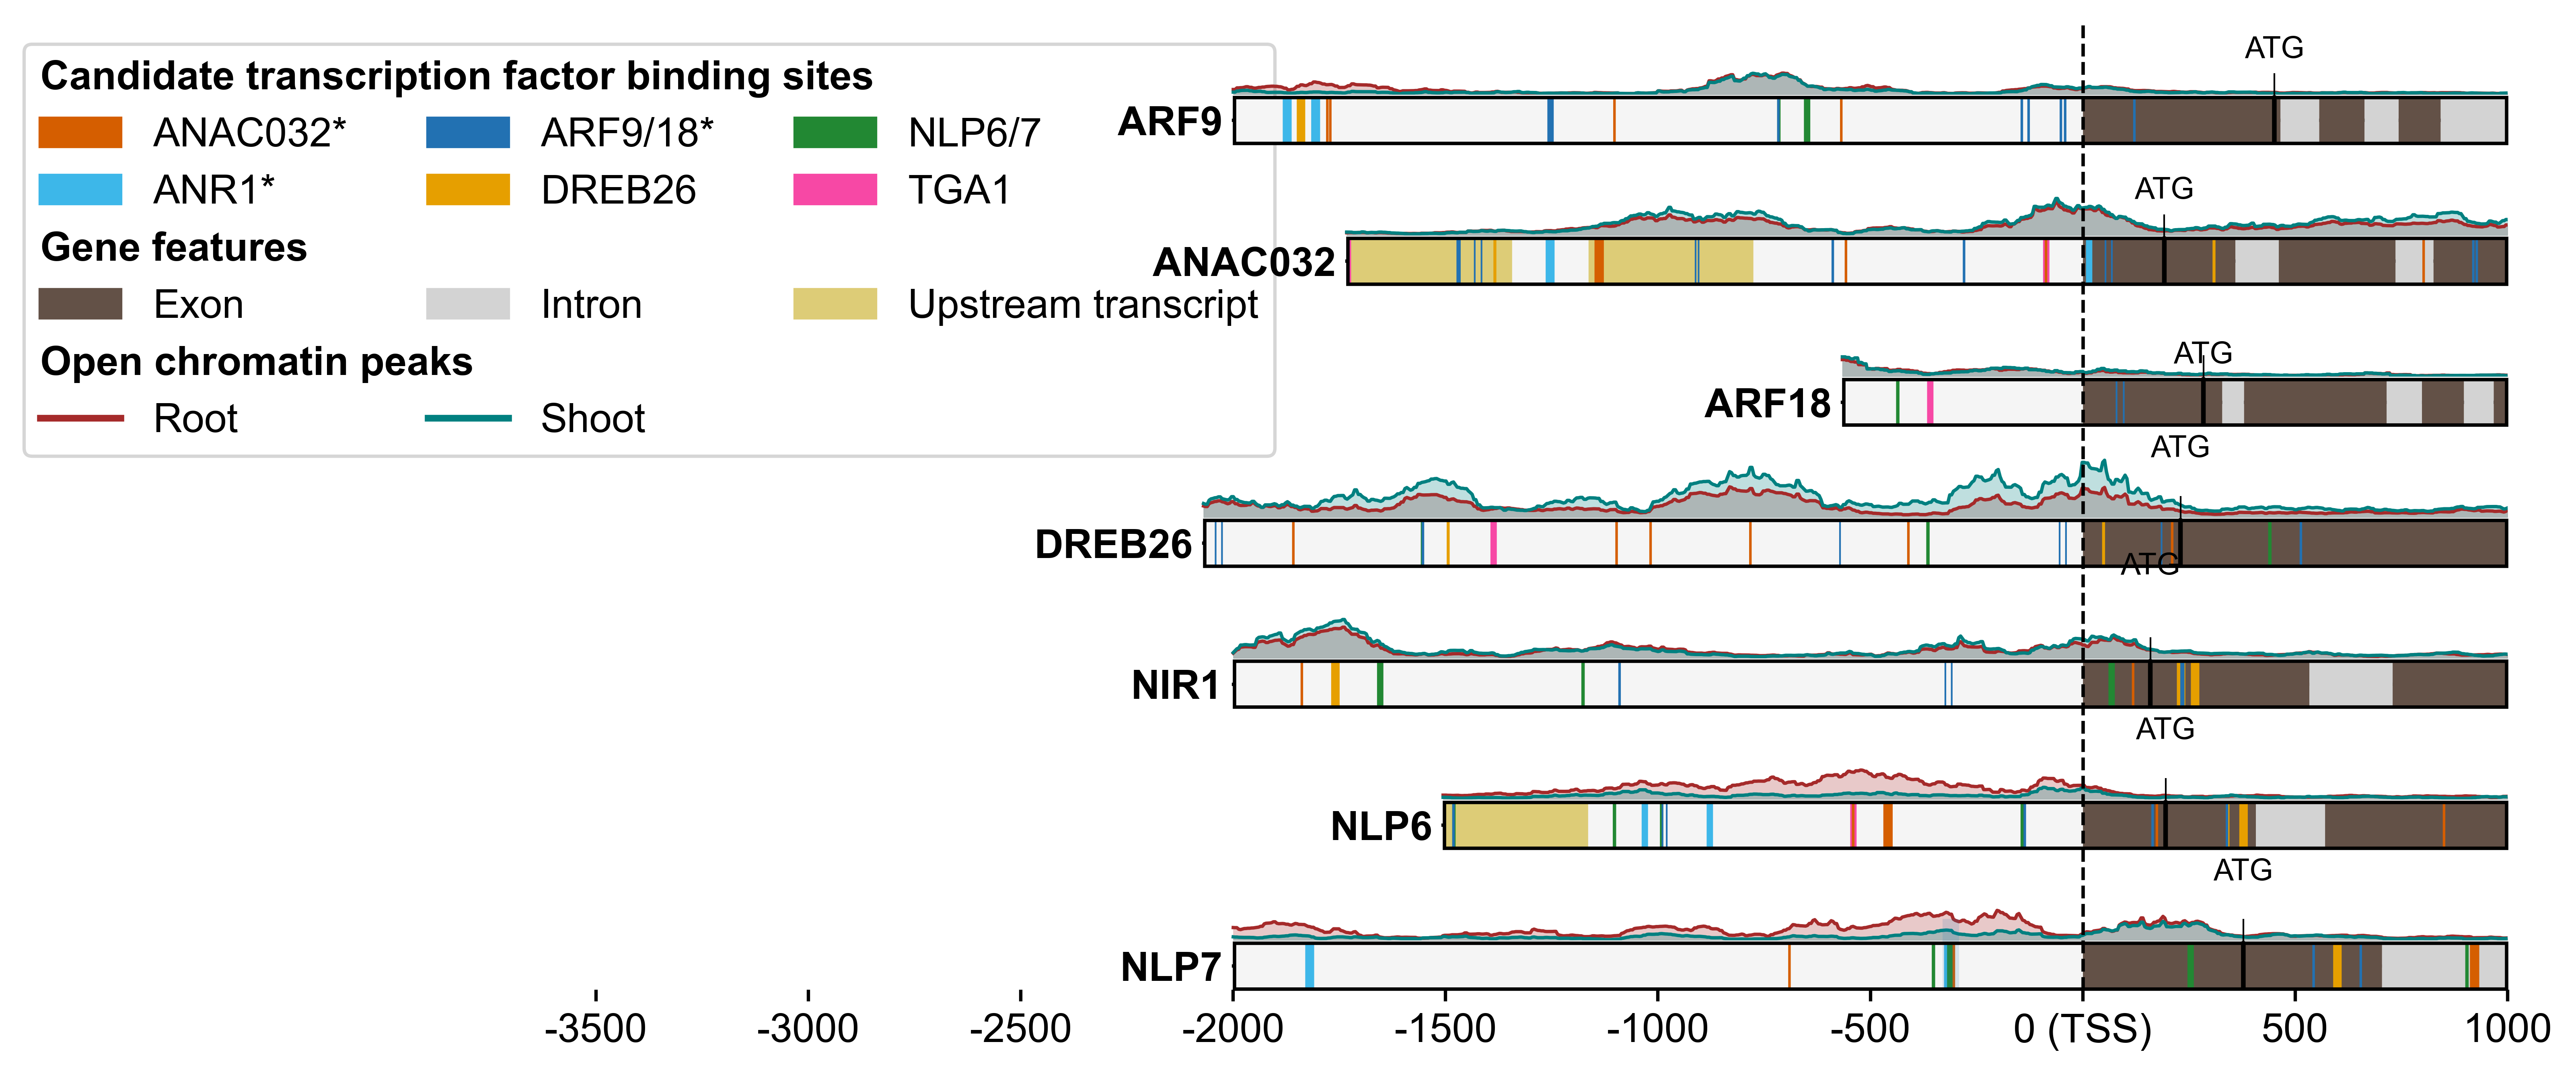

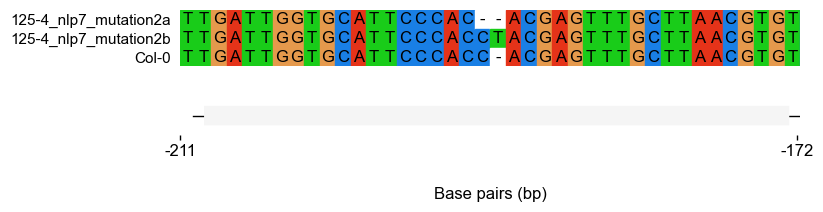

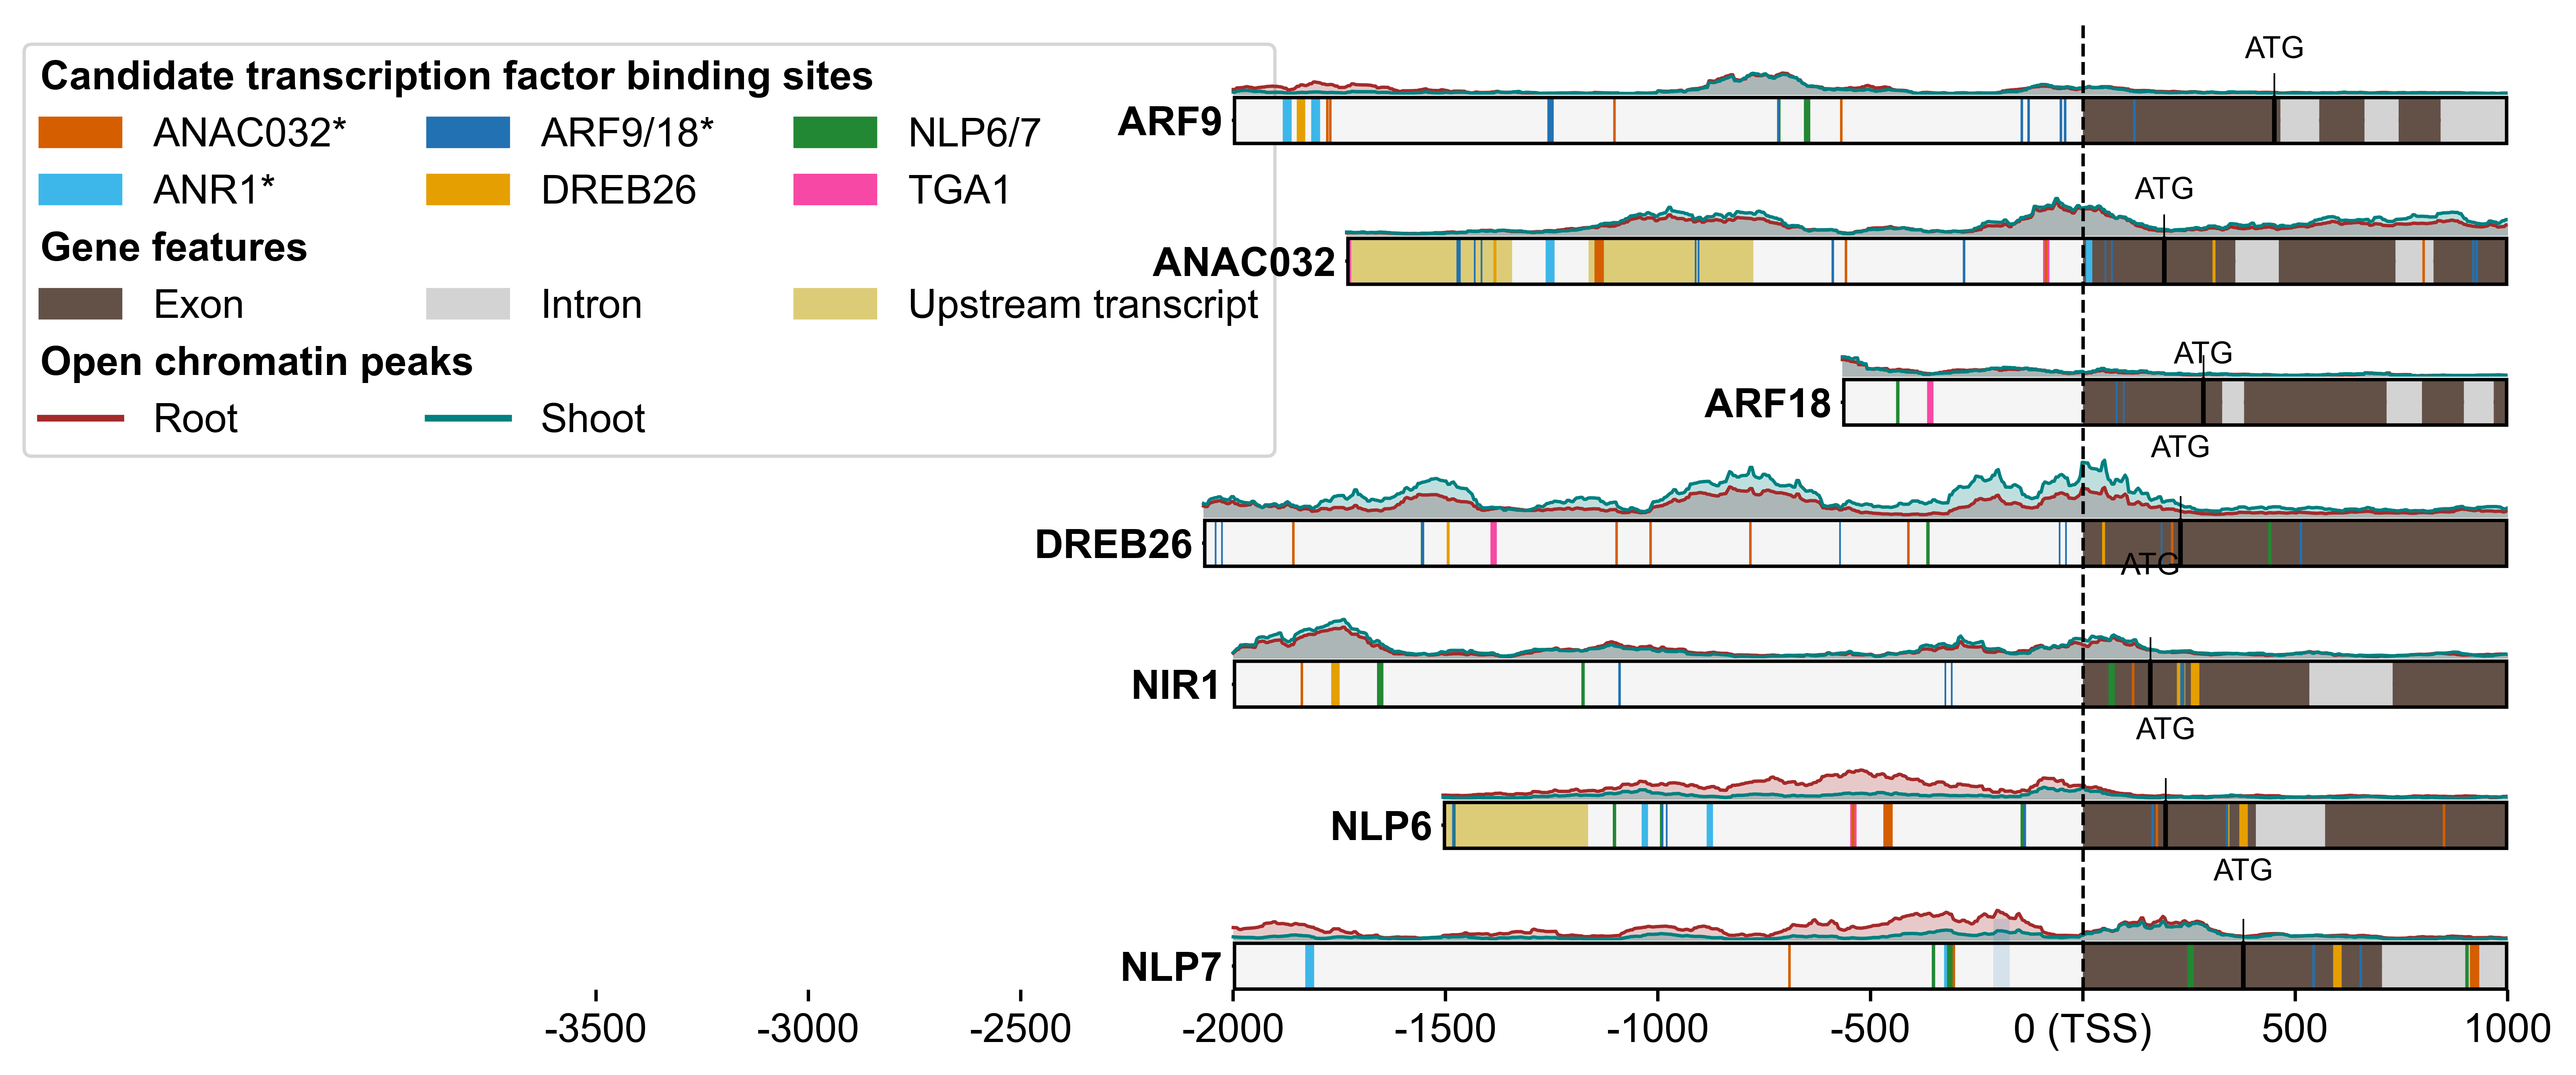

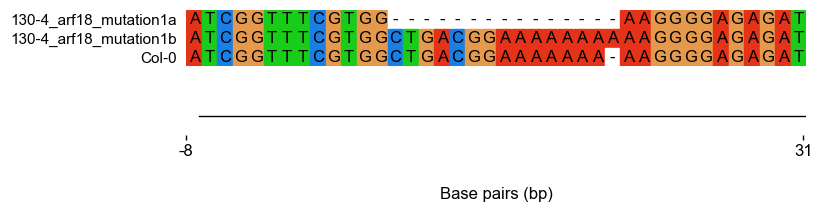

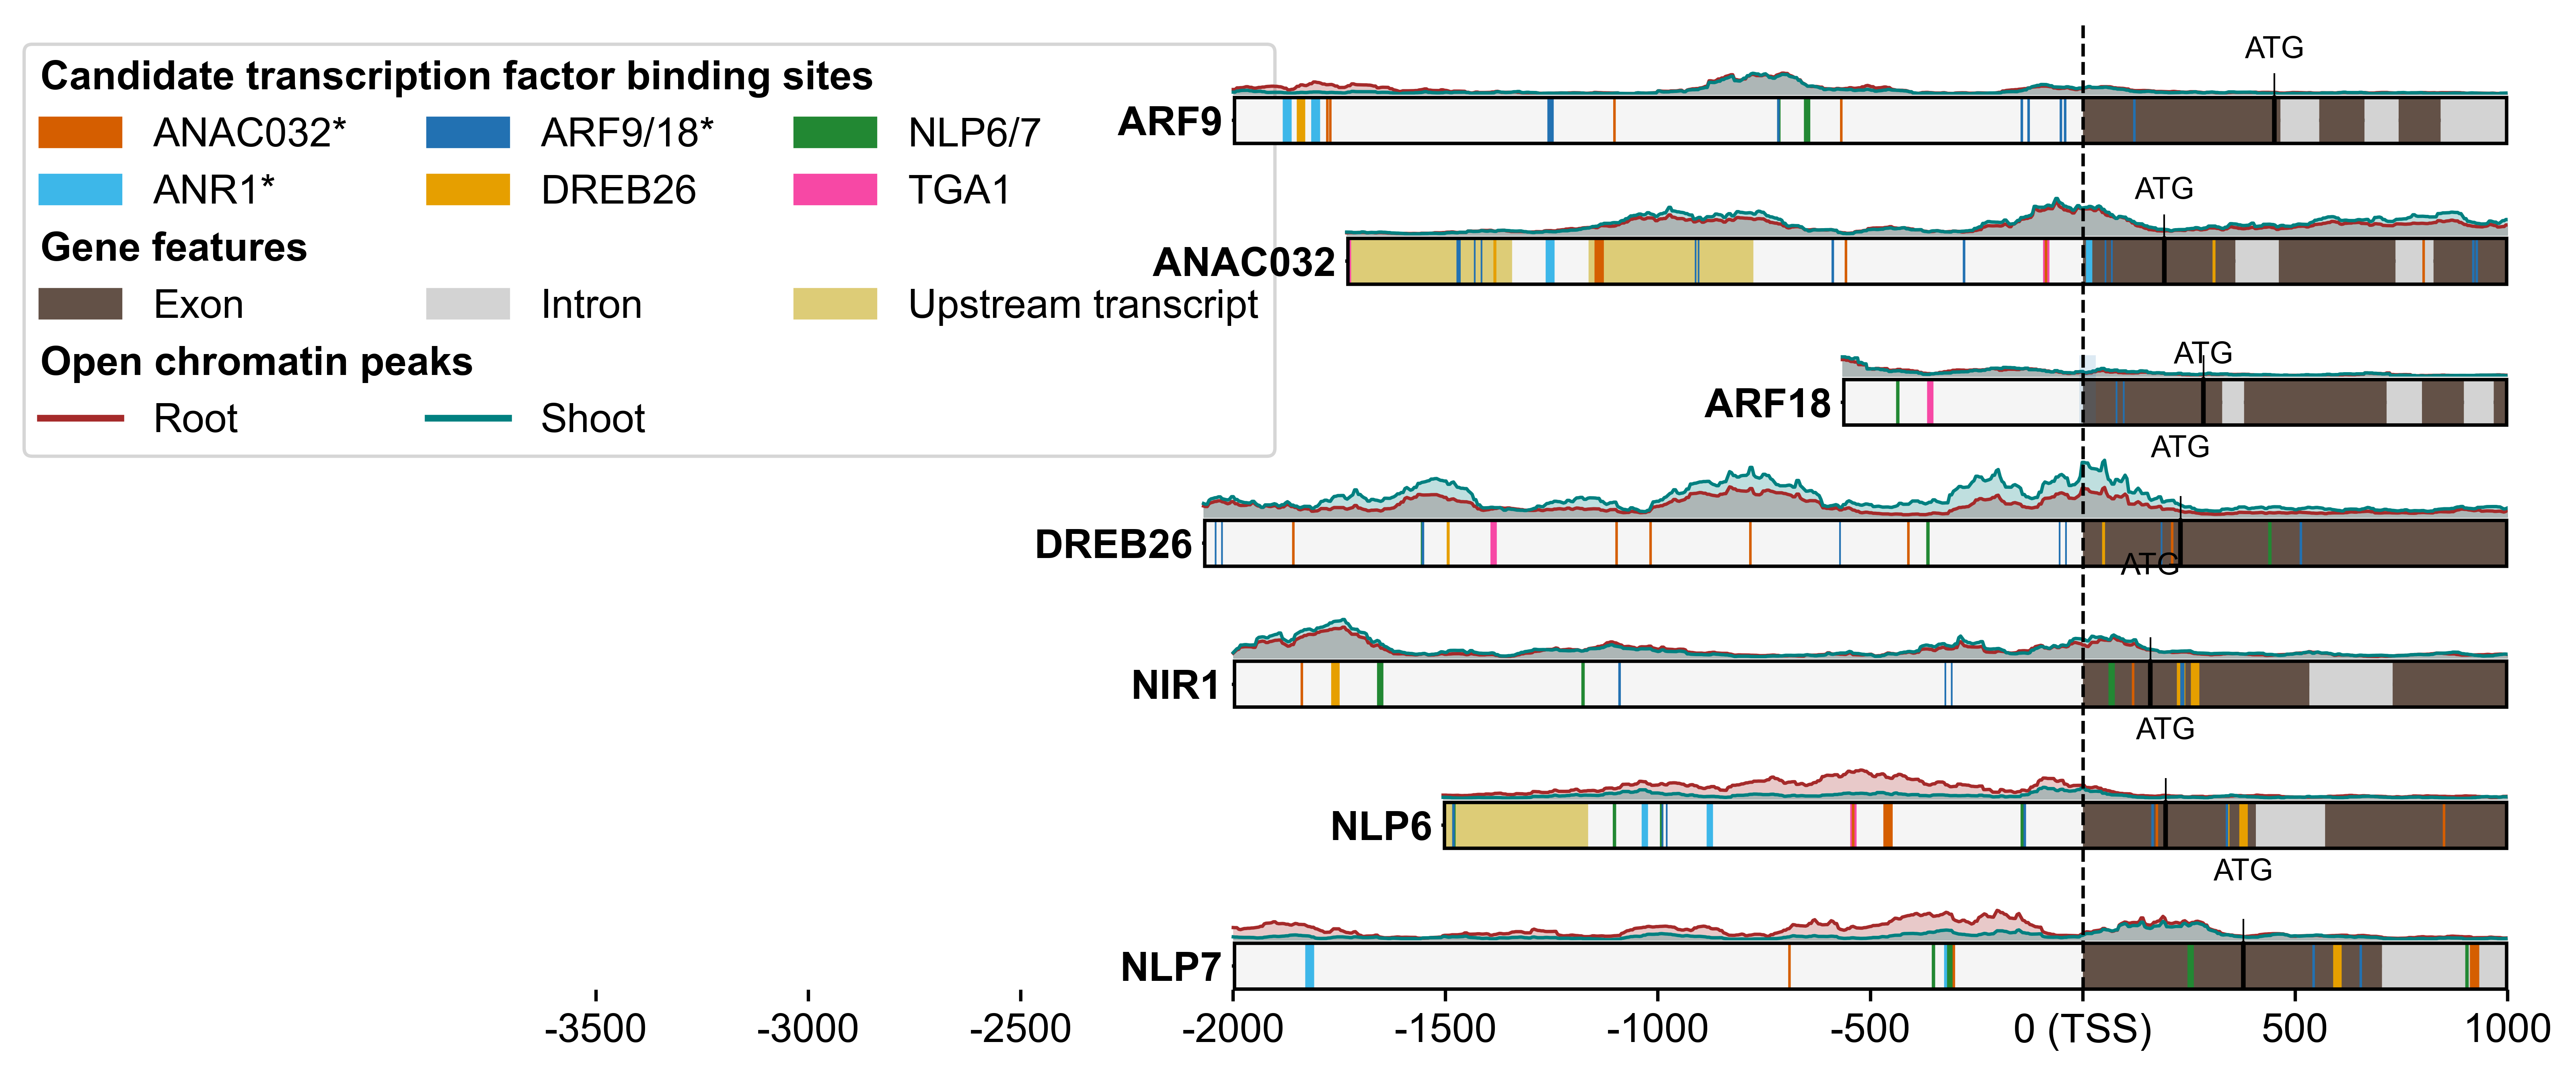

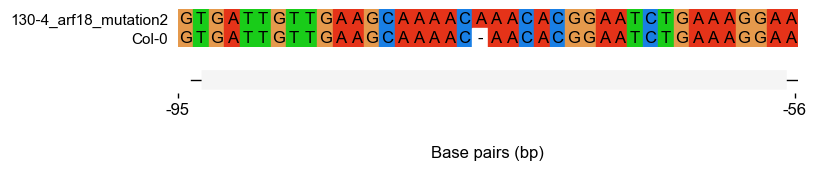

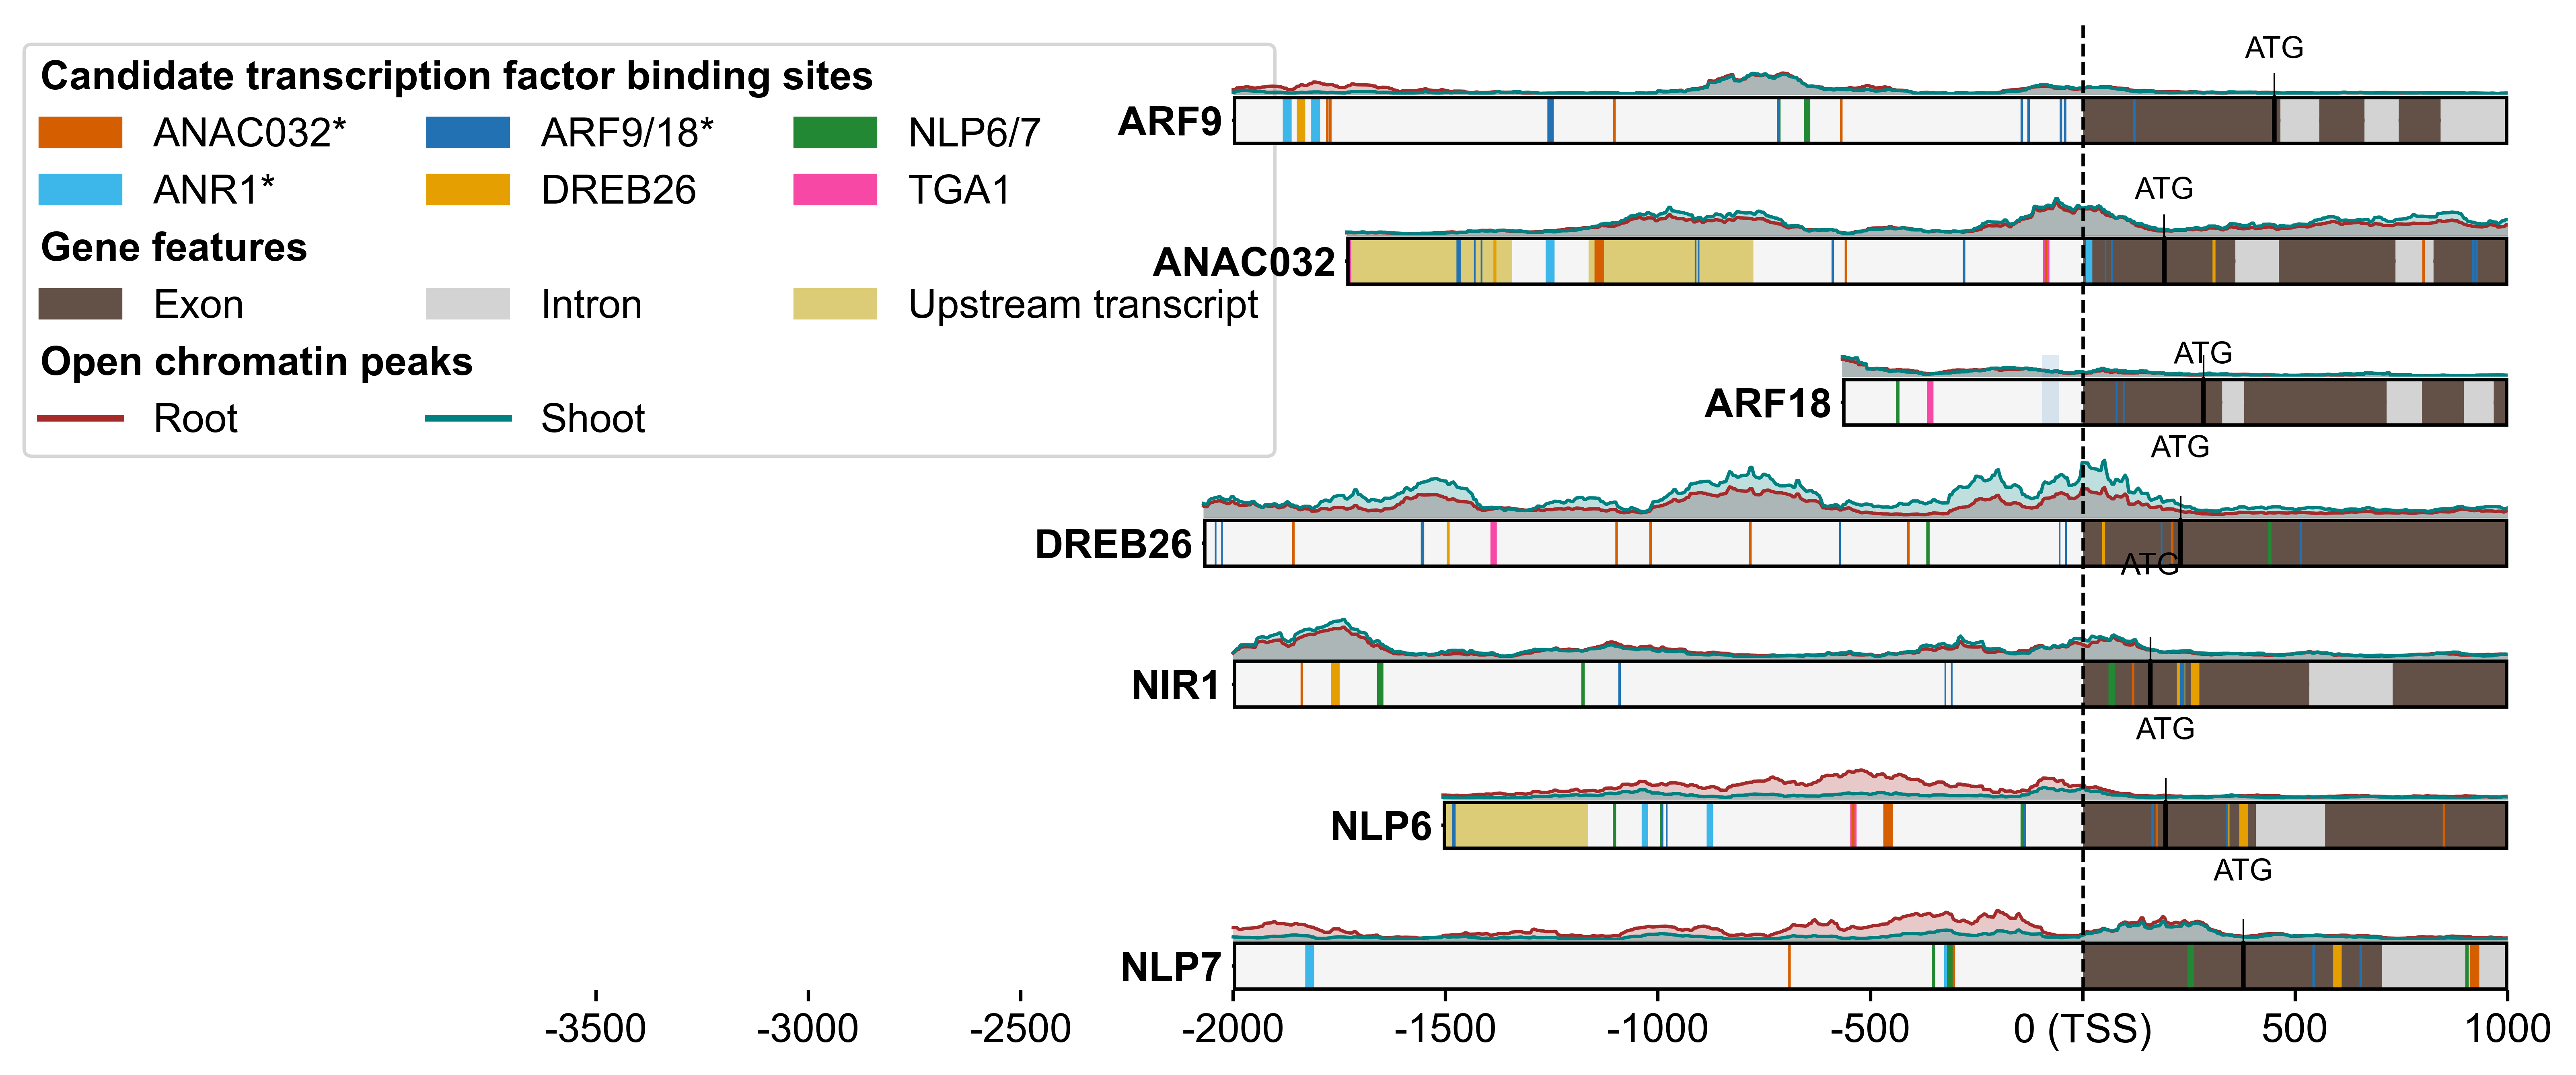

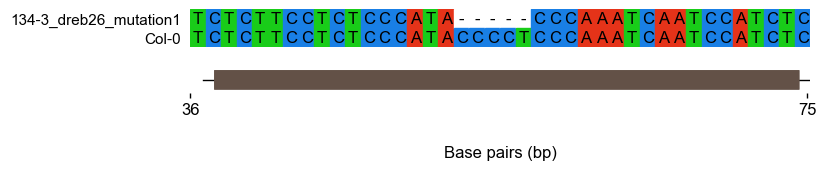

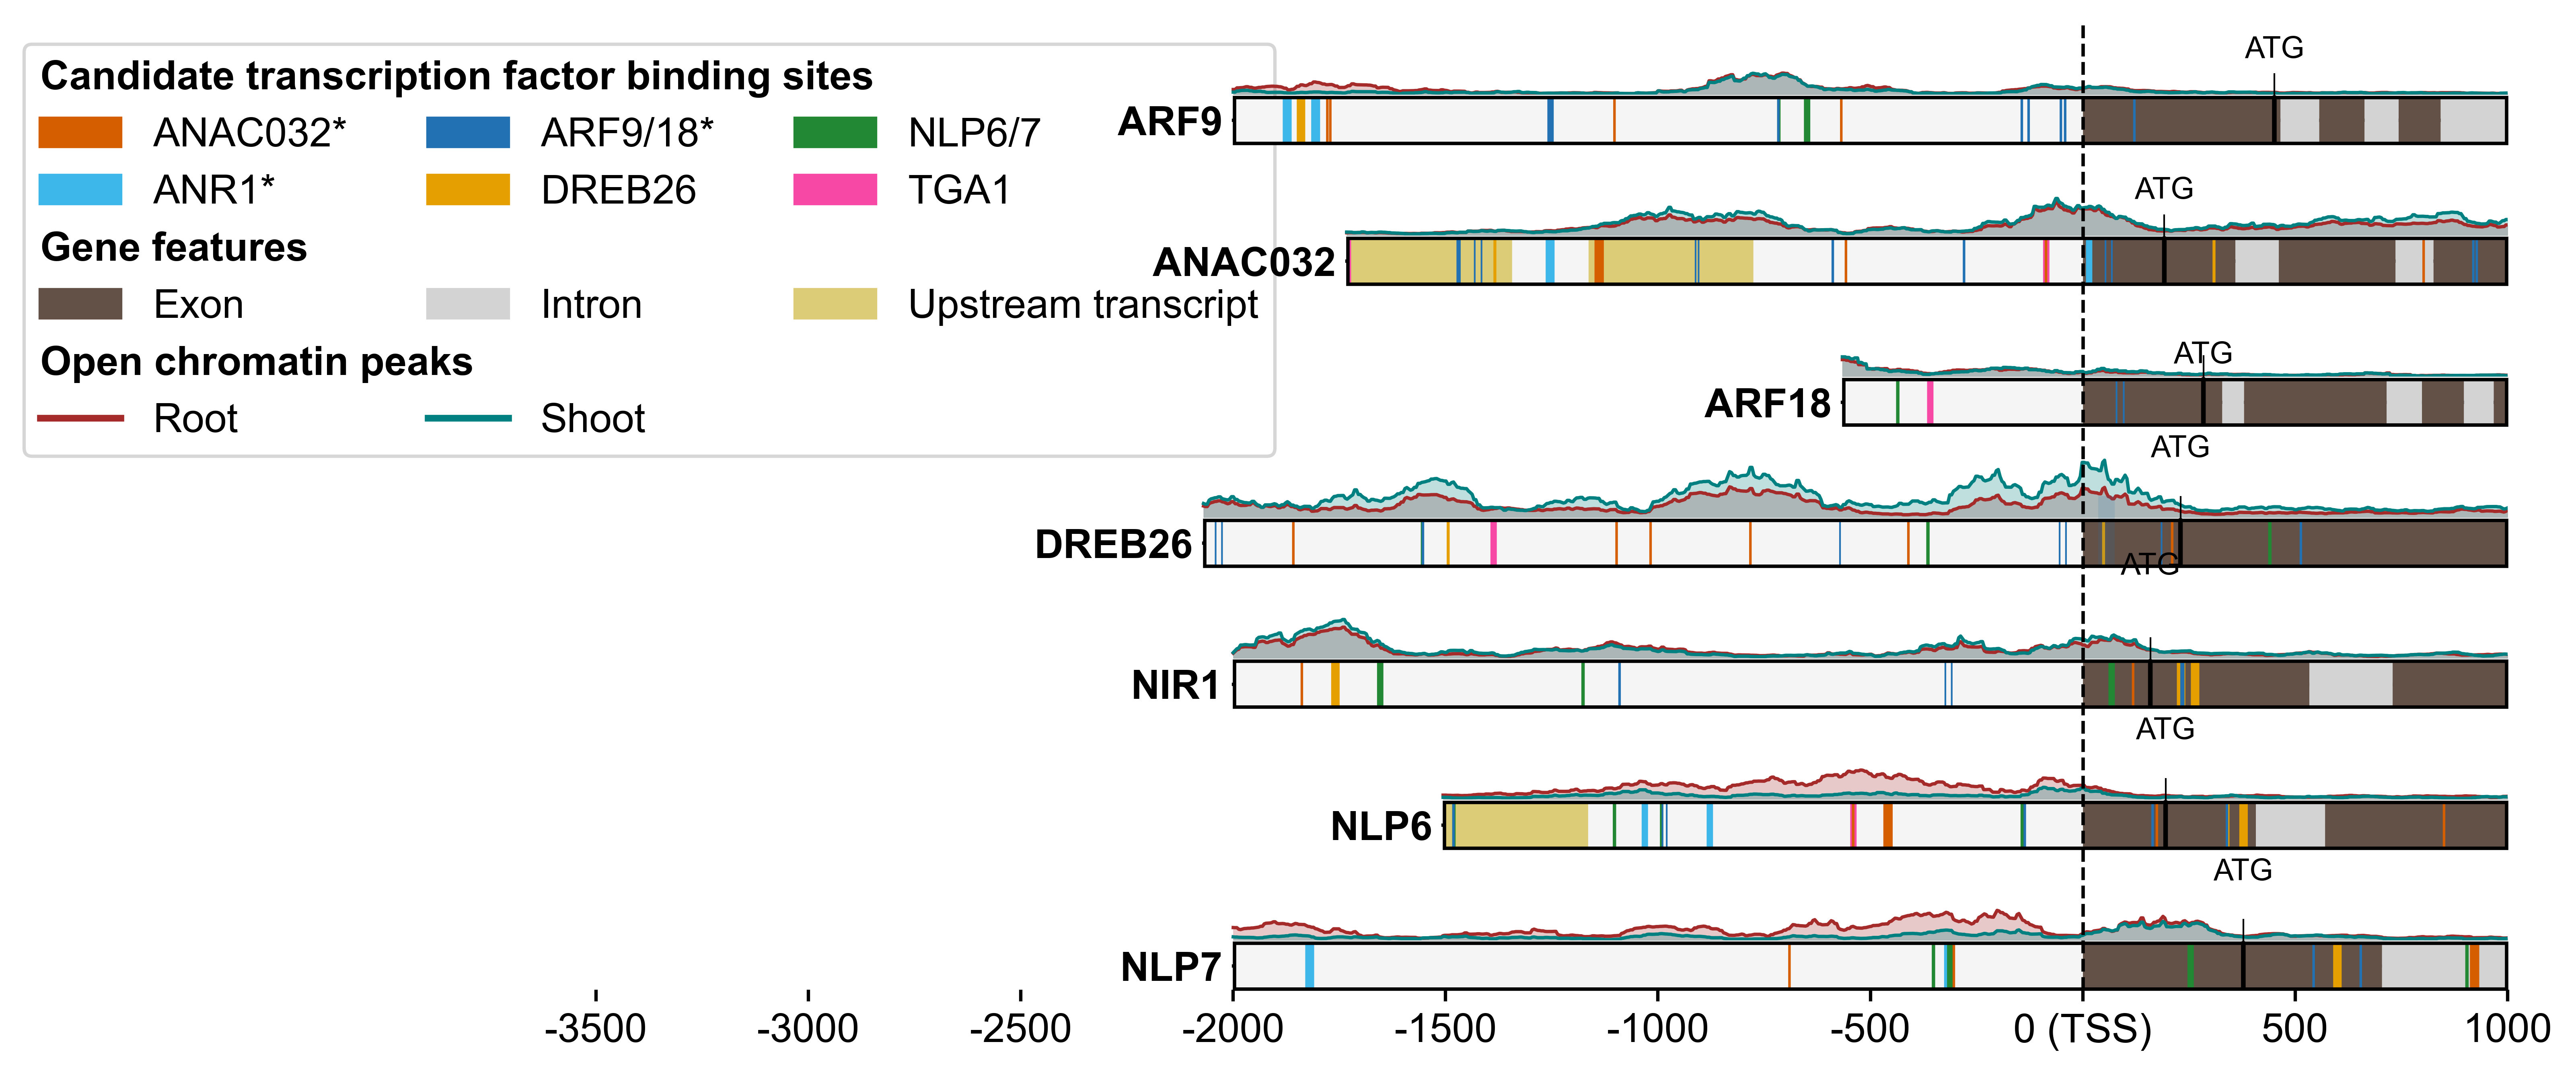

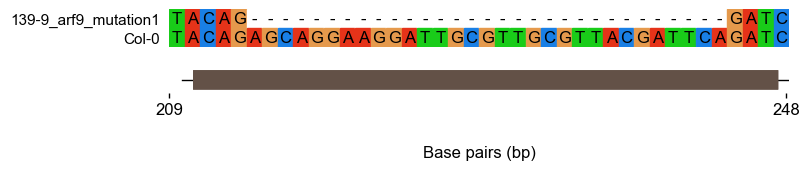

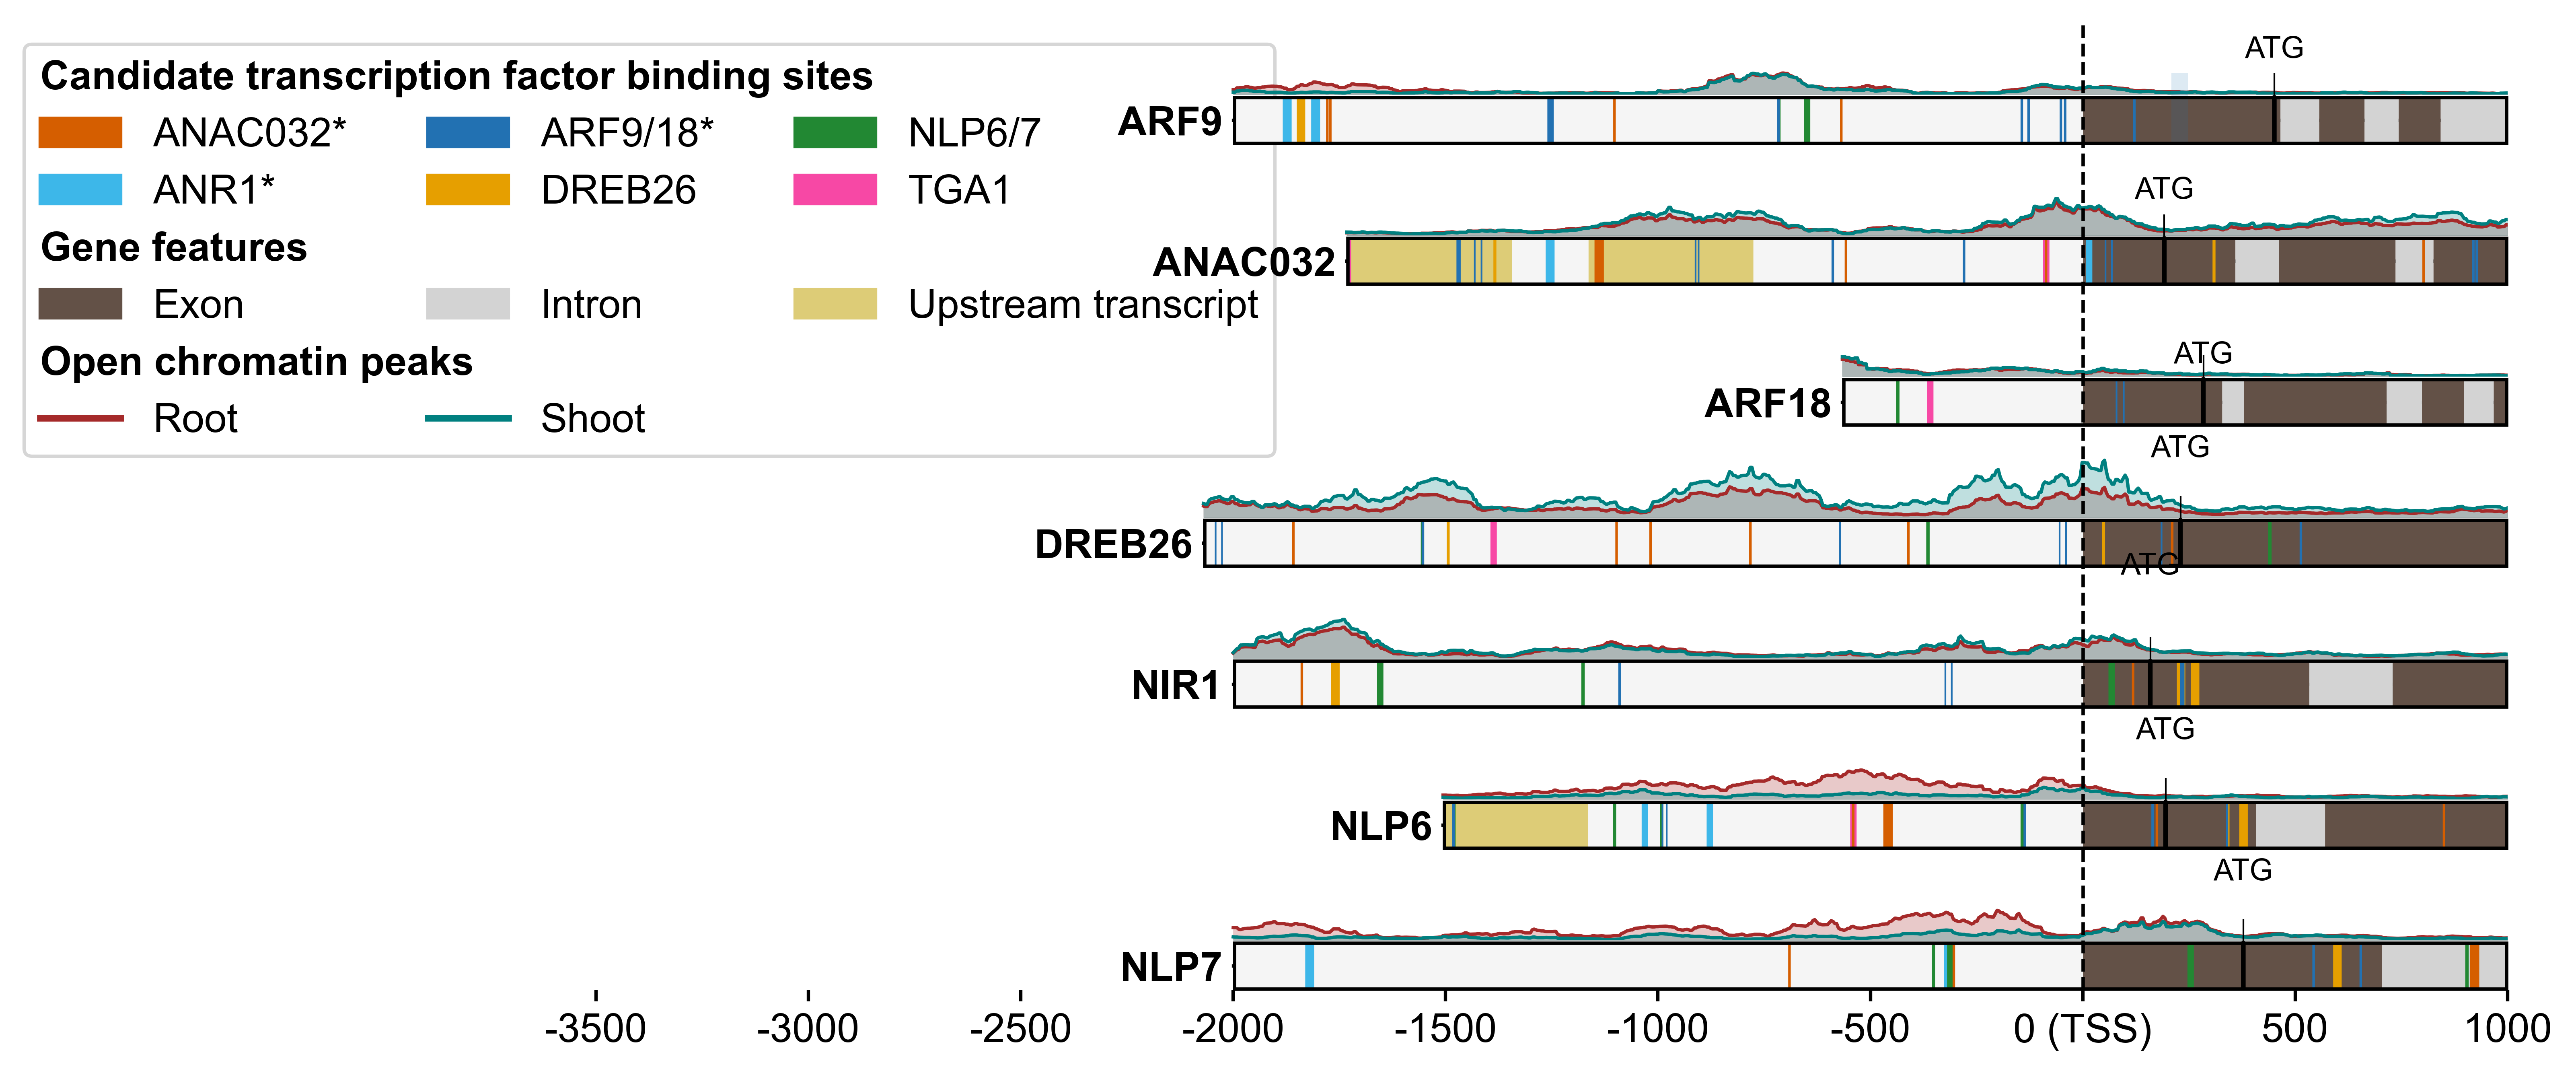

In [6]:
#read in the fasta file
input_location = '../../data/CRISPR_library/shortlist_mutations'


# update rcparams
set_rc_params()

#first make new folder
dirName = f"{input_location}/plots"
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory ", dirName, " created")
except FileExistsError:
    print("Directory ", dirName, " already exists")

#TSS locations for each gene
# NLP7 TSS: 12479528
# ARF9 TSS: 12451143
# ARF18 TSS: 22887889
# DREB26 TSS: 7696427
# need to check all coordinates on benchling, make all GB file numbering - done
# Then open in inkscape, draw box round TFBSs, consider adding additional TFBS boxes. Consider shifting overlapping TFBSs.
# Actually will need to reduce size of TFBSs - they are longer than original - so check on Benchling
#make plots 69-9 NLP7 mutation 1 12479771_12479810
make_plots('69-9_nlp7_mutation1','NLP7',input_location,12479771, 12479810, 12479528)
 
#make plots 125-4_arf9_mutation1_12451334_12451374

make_plots('125-4_arf9_mutation1','ARF9',input_location,12451335, 12451374, 12451143)

#make plots 125-4_nlp7_mutation1_12479197_12479236
make_plots('125-4_nlp7_mutation1','NLP7',input_location,12479198, 12479237, 12479528)

#make plots 125-4_nlp7_mutation2_12479316_12479355
make_plots('125-4_nlp7_mutation2','NLP7',input_location,12479317, 12479356, 12479528)

#make plots 130-4_arf18_mutation1_22887880_22887919
make_plots('130-4_arf18_mutation1','ARF18',input_location,22887881, 22887920, 22887889)

#make plots 130-4_arf18_mutation2_22887793_22887832
make_plots('130-4_arf18_mutation2','ARF18',input_location,22887794, 22887833, 22887889)

#make plots 134-3_dreb26_mutation1_7696462_7696501
make_plots('134-3_dreb26_mutation1','DREB26',input_location,7696463, 7696502, 7696427)

#make plots 139-9_arf9_mutation1_12451351_12451390
make_plots('139-9_arf9_mutation1','ARF9',input_location,12451352, 12451391, 12451143)
